# Análise e classificação de reviews de filmes

A base de dados utilizada nesse porojeto foi a "IMDB Dataset of 50K Movie Reviews", retirada do Kaggle. Essa base possue apenas duas colunas:
 - review - com os reviews feitos sobre os filmes 
 - sentiment - avaliação do review entre positivo ou negativo

Os objetivos pretendidos nesse notebook são:

 - Fazer uma análise exploratória do dataset "IMDB Dataset of 50K Movie Reviews" e implementar um modelo de ML que consiga classificar bem os reviews entre positivos e negativos. 

Para isso serão realizadas as seguintes etapas:
  - Fazer uma análise exploratória do dataset;
  - Fazer as limpezas e modificações necessárias;
  - Testar alguns modelos utilizando técnicas de vetorização diferentes.

In [1]:
# Importação das bibliotecas necesárias
import numpy as np
import pandas as pd

# Libs adicionais de NLP
import re
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bibliotecas para treinamento e cálculo de métricas 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Uso do core 'en_core_web_sm' do Spacy
nlp = spacy.load("en_core_web_sm")

# Download das stopworks do NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Análise da base

In [3]:
#Leitura dos datasets
df = pd.read_csv('IMDB Dataset.csv')

In [4]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.shape

(50000, 2)

In [7]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [8]:
# Verificando estrutura do texto da coluna review
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

- O texto da coluna review precisa de tratamento, pois está cheio de caracteres de HTML e outras coisas a mais.

### Pré tratamento dos dados

In [9]:
# Carregamento das stopwords em inglês
stopwords = nltk.corpus.stopwords.words('english')  

In [10]:
# Caracteres especiais a serem deletados da coluna review
filtro = stopwords + ['<br /><br />', '\n', '....']


In [11]:
# Função de tratamento
def tratamento_review(texto):

    texto = texto.lower() # Caixa baixa

    texto = re.sub("[0-9]+","", texto) # Exclusão de dígitos
    
    texto = re.sub(r"[^\w\s]", "",texto) # Exclusão de caracteres especiais

    texto = re.sub(' +', ' ', texto) # Exclusão de espaçamentos repetitivos entre as frases

    doc= nlp(texto) # Tokenização

    tokens=[token.text for token in doc if token.text not in filtro] # Filtragem adicional com os caracteres em stopwords

    return " ".join(tokens)

In [12]:
# Aplicando a função acima na coluna review
df['review'] = df['review'].apply(lambda x: tratamento_review(x))

In [13]:
# Verificando o texto depois dos tratamentos realizados
df.review[0]

'one reviewers mentioned watching oz episode hooked right exactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows would nt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz nt mess around first episode ever saw struck nasty surreal could nt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates

In [14]:
# Distribuição da variável de interesse
df[['sentiment']].value_counts(sort = False)

sentiment
negative     25000
positive     25000
dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

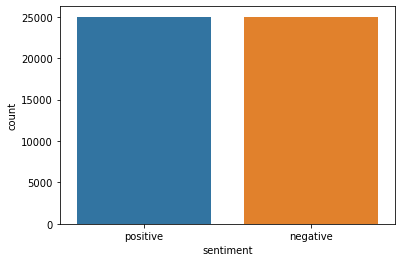

In [15]:
sns.countplot(data=df, x="sentiment")

- A variável de interesse está bem distribuída, 50% para cada categoria, sem valores nulos ou duplicados, o que ajudará bastante na hora da modelagem.

In [16]:
# Transformando a coluna categórica em booleana:
# positivo = 1
# negativo = 0
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

- Optei por trabalhar com a coluna review como booleana, para isso fiz a transformação acima.

In [17]:
# Verificando o dataset depois dessa transformação
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,1
1,wonderful little production br br filming tech...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake thinks zombie...,0
4,petter matteis love time money visually stunni...,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### Modelagem

- Nesta etapa serão gerados alguns Pipelines com a utilização de 3 modelos:
  - LinearSVC (Support Vector Classification) - implementa um algoritmo de classificação, o SVM, ou máquina de vetores de suporte. Ele classifica o conjunto de dados, tentando separar de maneira linear as classes que estão presentes no conjunto de dados.

  - Naive Bayes Classifier - realiza uma classificação probabilística de observações, tomando como premissa a suposição de independência entre as variáveis do problema.
  
  - Random Forest Classifier - Florestas aleatórias ou florestas de decisão aleatória é um método de aprendizado conjunto para classificação, regressão e outras tarefas que opera construindo uma infinidade de árvores de decisão em tempo de treinamento.
  
- Cada modelo será testado com duas técnicas de vetorização:
  - CountVectorizer - Ele é usado para transformar um determinado texto em um vetor com base na frequência (contagem) de cada palavra que ocorre em todo o texto.
  
  - TfidfVectorizer - Pode ser definido como o cálculo da relevância de uma palavra em uma série ou corpus para um texto. O significado aumenta proporcionalmente ao número de vezes que uma palavra aparece no texto, mas é compensado pela frequência da palavra no corpus (conjunto de dados).
  
- O objetivo nessa etapa é conseguir gerar um modelo que consiga classificar bem os dados.


In [19]:
#Train Test Split
from sklearn.model_selection import train_test_split

X = df['review']  
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Criando um Pipeline com CountVectorizer e LinearSVC

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

count_svc = Pipeline([('count_vect', CountVectorizer(analyzer='word', stop_words=stopwords)),
                     ('svc', LinearSVC()),
])

# Feed the training data through the pipeline
count_svc.fit(X_train, y_train)

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('count_vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', LinearSVC())])

In [21]:
predictions = count_svc.predict(X_test)

In [22]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7411
           1       0.87      0.87      0.87      7589

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



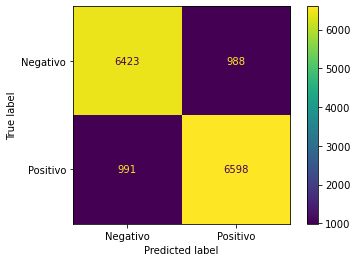

In [23]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Positivo'])
_ = disp.plot(values_format='d')

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


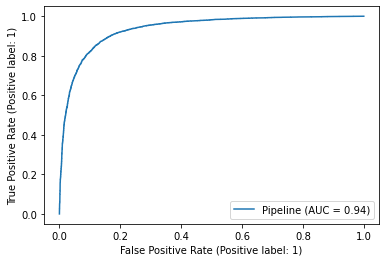

In [24]:
# Visualizando a Curva Roc do Modelo
plot_roc_curve(count_svc, X_test, y_test)

### Criando um Pipeline com TfidfVectorizer e LinearSVC

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:

tfidf_svc = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', stop_words=stopwords)),
                     ('svc', LinearSVC()),
])

# Feed the training data through the pipeline
tfidf_svc.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', LinearSVC())])

In [27]:
predictions = tfidf_svc.predict(X_test)

In [28]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7411
           1       0.89      0.90      0.90      7589

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



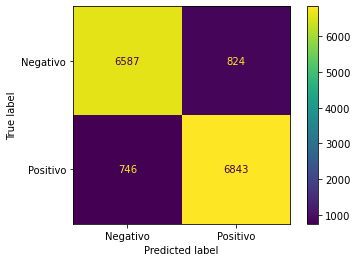

In [29]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Positivo'])
_ = disp.plot(values_format='d')

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


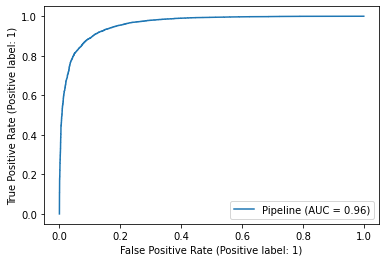

In [30]:
# Visualizando a Curva Roc do Modelo
plot_roc_curve(tfidf_svc, X_test, y_test)

### Criando um Pipeline com CountVectorizer e Naive Bayes Classifier

In [31]:
from sklearn.naive_bayes import MultinomialNB

count_bayes = Pipeline([('count_vec', CountVectorizer(analyzer='word', stop_words=stopwords)),
                     ('naive_bayes', MultinomialNB()),
])

# Feed the training data through the pipeline
count_bayes.fit(X_train, y_train)

Pipeline(steps=[('count_vec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('naive_bayes', MultinomialNB())])

In [32]:
predictions = count_bayes.predict(X_test)

In [33]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      7411
           1       0.88      0.84      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



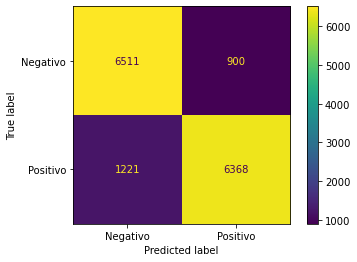

In [34]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Positivo'])
_ = disp.plot(values_format='d')

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


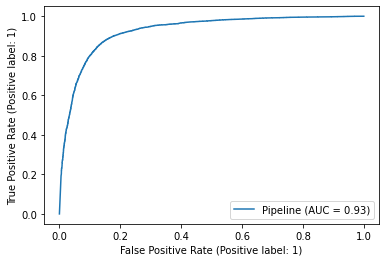

In [35]:
# Visualizando a Curva Roc do Modelo
plot_roc_curve(count_bayes, X_test, y_test)

### Criando um Pipeline com TfidfVectorizer e Naive Bayes Classifier

In [36]:

tfidf_bayes = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', stop_words=stopwords)),
                     ('naive_bayes', MultinomialNB()),
])

# Feed the training data through the pipeline
tfidf_bayes.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('naive_bayes', MultinomialNB())])

In [37]:
predictions = tfidf_bayes.predict(X_test)

In [38]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      7411
           1       0.88      0.85      0.86      7589

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



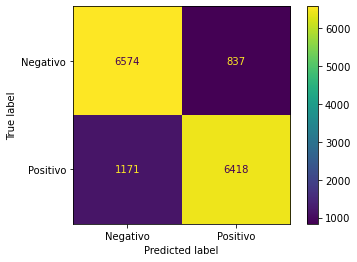

In [39]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Positivo'])
_ = disp.plot(values_format='d')

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


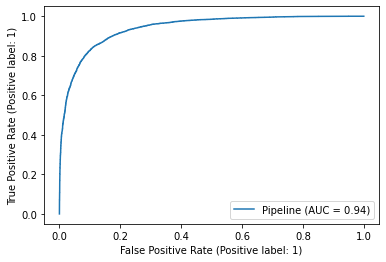

In [40]:
# Visualizando a Curva Roc do Modelo
plot_roc_curve(tfidf_bayes, X_test, y_test)

### Criando um Pipeline com CountVectorizer e Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

count_rf = Pipeline([('count_vec', CountVectorizer(analyzer='word', stop_words=stopwords)),
                     ('rf', RandomForestClassifier(n_estimators = 5, random_state = 42)),
])

# Feed the training data through the pipeline
count_rf.fit(X_train, y_train)

Pipeline(steps=[('count_vec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(n_estimators=5, random_state=42))])

In [42]:
predictions = count_rf.predict(X_test)

In [43]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      7411
           1       0.73      0.73      0.73      7589

    accuracy                           0.73     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.73      0.73      0.73     15000



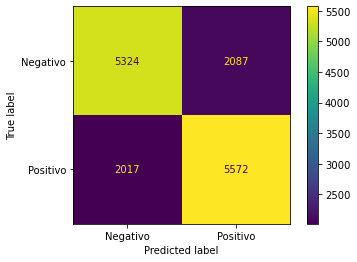

In [44]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Positivo'])
_ = disp.plot(values_format='d')

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


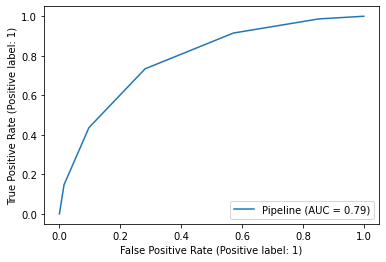

In [45]:
# Visualizando a Curva Roc do Modelo
plot_roc_curve(count_rf, X_test, y_test)

### Criando um Pipeline com TfidfVectorizer e Random Forest Classifier

In [46]:
tfidf_rf = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', stop_words=stopwords)),
                     ('rf', RandomForestClassifier(n_estimators = 5, random_state = 42)),
])

# Feed the training data through the pipeline
tfidf_rf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(n_estimators=5, random_state=42))])

In [47]:
predictions = tfidf_rf.predict(X_test)

In [48]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      7411
           1       0.73      0.72      0.72      7589

    accuracy                           0.72     15000
   macro avg       0.72      0.72      0.72     15000
weighted avg       0.72      0.72      0.72     15000



In [49]:
print("Acurácia: ", accuracy_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions, pos_label=0))
print('Recall:', recall_score(y_test, predictions, pos_label=0))
print('F1 Score:', f1_score(y_test, predictions))

Acurácia:  0.7222
Precision: 0.7170770877944326
Recall: 0.7229793550128187
F1 Score: 0.7243500694582259


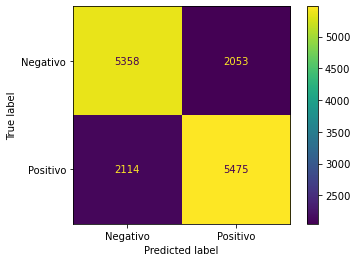

In [50]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Positivo'])
_ = disp.plot(values_format='d')

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


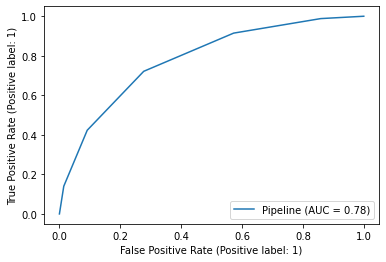

In [51]:
# Visualizando a Curva Roc do Modelo
plot_roc_curve(tfidf_rf, X_test, y_test)

### Comparação dos modelos:

/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/karine/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve`

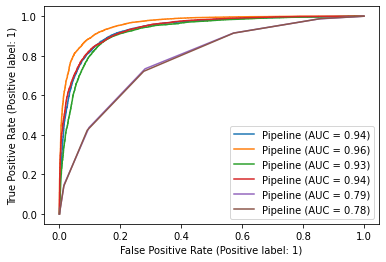

In [52]:
# Comparando as curvas roc dos modelos
classifiers = [count_svc,tfidf_svc,count_bayes,tfidf_bayes,count_rf,tfidf_rf]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

- O gráfico acima compara a curva roc de cada pipeline gerado.
- O segundo pipeline que utilizou TfidfVectorizer e LinearSVC, foi o que obteve o melhor resultado.
- Os dois últimos pipelines que utilizou o Random Forest e o CountVectorizer/ TfidfVectorizer foram os que apresentaram piores resultados.

In [54]:
# Comparando as métricas dos modelos 
j = 1
for i in classifiers:
    y_pred = i.predict(X_test)
    print(f'**Modelo {j}**')
    print(f'Acurácia: {round(accuracy_score(y_test, y_pred), 2)}\nPrecisão: {round(precision_score(y_test, y_pred), 2)}\nRecall: {round(recall_score(y_test, y_pred), 2)}\nRF1 Score: {round(f1_score(y_test, y_pred), 2)}')
    print('__________________')
    j += 1

**Modelo 1**
Acurácia: 0.87
Precisão: 0.87
Recall: 0.87
RF1 Score: 0.87
__________________
**Modelo 2**
Acurácia: 0.9
Precisão: 0.89
Recall: 0.9
RF1 Score: 0.9
__________________
**Modelo 3**
Acurácia: 0.86
Precisão: 0.88
Recall: 0.84
RF1 Score: 0.86
__________________
**Modelo 4**
Acurácia: 0.87
Precisão: 0.88
Recall: 0.85
RF1 Score: 0.86
__________________
**Modelo 5**
Acurácia: 0.73
Precisão: 0.73
Recall: 0.73
RF1 Score: 0.73
__________________
**Modelo 6**
Acurácia: 0.72
Precisão: 0.73
Recall: 0.72
RF1 Score: 0.72
__________________


### Comentários finais: 
 - Dentre os modelos testados, o que obteve as melhores métricas foi o LinearSVC, tanto utilizando o CountVectorizer como o TfidfVectorizer, se mostrando melhor com o último.

   - A utilização da técnica de vetorização TfidfVectorizer melhorou seu desempenho;
   - Obteve maior número de acertos, diminuindo assim a quantidade de erros, com  isso conseguiu melhorar tanto o recall como o precission e assim melhorando as demais métricas de avaliação.
   
- Devido aos comentários acima o modelo escolhido foi o Modelo 2 "Pipeline com TfidfVectorizer e LinearSVC".

 - O modelo com pior performance foi o Random Forest, tanto utilizando o CountVectorizer como o TfidfVectorizer.

 - Os demais modelos não tiveram uma diferença significante em relação ao tipo de vetorização utilizado.

- Próximos passos: 
  - Mexer nos parâmetros do modelo escolhido para tentar melhorar a quantidade de acertos.



   